# Рекомендация тарифов

## Откройте и изучите файл

In [78]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [79]:
calls=pd.read_csv('/datasets/users_behavior.csv') 
calls.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [80]:
calls.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [81]:
calls['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

## Разбейте данные на выборки

In [82]:
calls_train, calls_valid=train_test_split(calls, test_size=0.4, random_state=12345, stratify=calls['is_ultra']) 
calls_valid, calls_test=train_test_split(calls_valid, test_size=0.5, random_state=12345, stratify=calls_valid['is_ultra']) 
print(calls_train.shape)
print(calls_valid.shape)
print(calls_valid.shape)

(1928, 5)
(643, 5)
(643, 5)


По условиям задачи, необходимо разделить данные на три выбоки:обучающую, валидационную и тестовую. Разбила 60%/20%/20% соответственно.

## Исследуйте модели

### Исследуем первую модель, где целевым признаком является название тарифа, а для предсказаний берём все остальные признаки имеющиеся в данных

In [83]:
features_train = calls_train.drop(['is_ultra'], axis=1) 
target_train = calls_train['is_ultra']
features_valid = calls_valid.drop(['is_ultra'], axis=1)
target_valid = calls_valid['is_ultra']
features_test=calls_test.drop(['is_ultra'], axis=1)
target_test=calls_test['is_ultra']
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)
model=DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predictions_valid=model.predict(features_valid)
print(accuracy_score(target_valid, predictions_valid))

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)
0.7013996889580093


### Исследуем модель, где целевой признак, также название тарифа, а для предсказаний берём количество звонков и количество sms сообщений.

In [84]:
features_train1 = calls_train.drop(['is_ultra', 'minutes', 'mb_used'], axis=1)
target_train1 = calls_train['is_ultra']
features_valid1 = calls_valid.drop(['is_ultra', 'minutes', 'mb_used'], axis=1)
target_valid1 = calls_valid['is_ultra']
features_test1=calls_test.drop(['is_ultra', 'minutes', 'mb_used'], axis=1)
target_test1=calls_test['is_ultra']
print(features_train1.shape) 
print(target_train1.shape)
print(features_valid1.shape)
print(target_valid1.shape)
print(features_test1.shape)
print(target_test1.shape)
model=DecisionTreeClassifier(random_state=12345)
model.fit(features_train1, target_train1)
predictions_valid1=model.predict(features_valid1)
print(accuracy_score(target_valid1, predictions_valid1))

(1928, 2)
(1928,)
(643, 2)
(643,)
(643, 2)
(643,)
0.6811819595645412


Возьмем для проверки гиперпараметров 1ую модель, где в качестве признаков мы взяли все параметры датасета. Результат предсказаний в ней выше

In [85]:
best_model=None
best_result=0
for depth in range(1,11):
    model=DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid=model.predict(features_valid)
    result=accuracy_score(target_valid, predictions_valid)
    if result>best_result:
        best_model=model
        best_result=result
display(best_result, best_model)        

0.80248833592535

DecisionTreeClassifier(max_depth=8, random_state=12345)

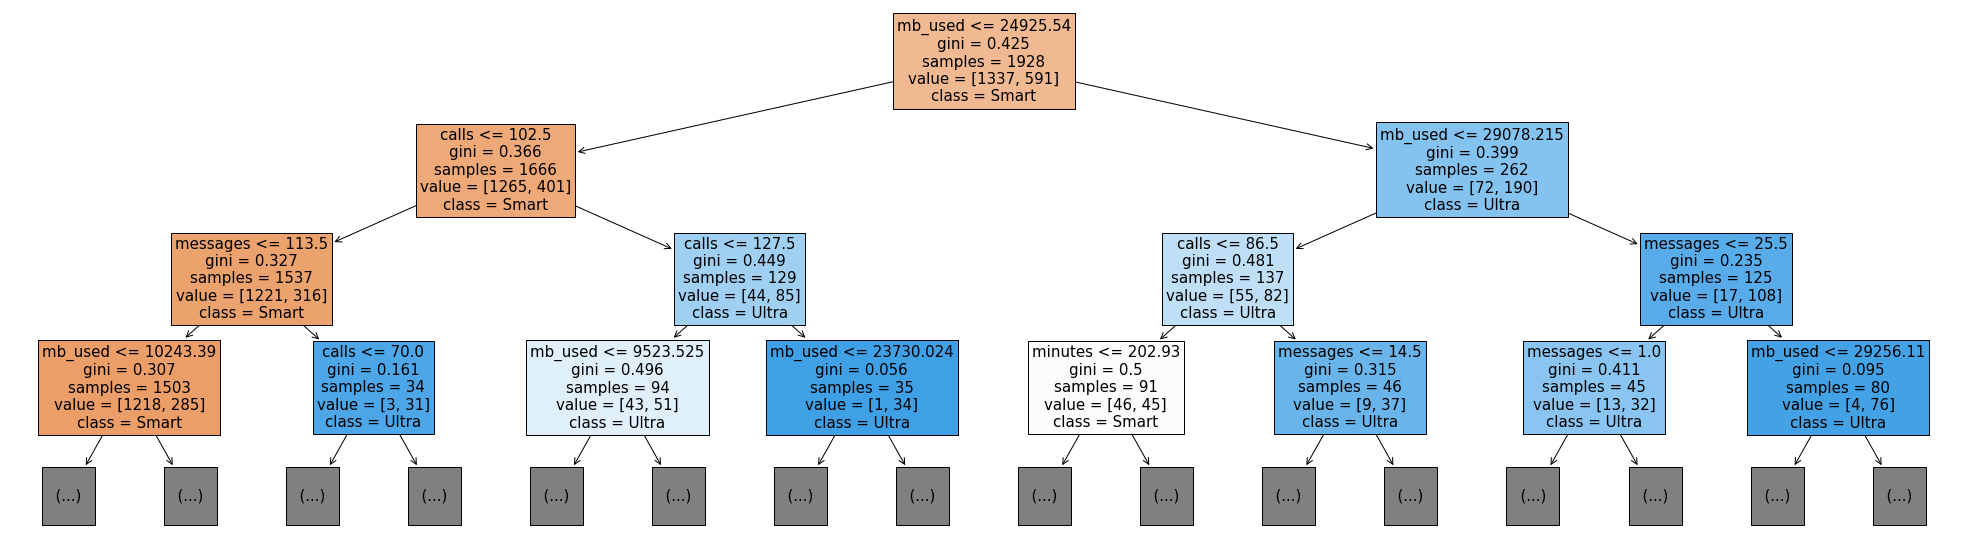

In [86]:
fig = plt.figure(figsize=(35,10))
_ = plot_tree(best_model, 
               feature_names=features_valid.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15, max_depth=3)

In [87]:
predictions_train = model.predict(features_train)
result_train = accuracy_score(target_train, predictions_train)

Проверим гиперпараметр решающего дерева, лучший результат получается при значении 3.

In [88]:
%%time
best_model_df = None
best_result = 0
for est in range(1, 11):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result:
            best_model_df=model 
            best_result = result
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Accuracy наилучшей модели на валидационной выборке: 0.807153965785381
CPU times: user 1.71 s, sys: 11 ms, total: 1.72 s
Wall time: 1.73 s


## Проверьте модель на тестовой выборке

In [89]:
predictions_test=best_model_df.predict(features_test)
print("Тестовая выборка:", accuracy_score(target_test, predictions_test))

Тестовая выборка: 0.8102643856920684


In [91]:
dummy_clf=DummyClassifier(strategy='most_frequent', random_state=1)
dummy_clf.fit(features_train, target_train)
dummy_clf.predict(features_test)
dummy_clf.score(features_test, target_test)

0.6936236391912908

ВЫВОД: В ходе работы я проанализировала и изучила данные, увидела что большинство клиентов пользуются тарифом Смарт, гораздо меньше пользуются тарифом Ультра. Исходя из имеющихся данных составила пару моделей для прогноза и пришла к выводу что лучше использовать модель где признаками являются все данные: количество звонков, продолжительность звонков, количество сообщений и трафик интернета. Все эти параметры могут повлиять на выбор тарифа пользователем. Проверила модель на тестовой выборке и получила точность прогноза 0.78.